<a href="https://colab.research.google.com/github/jaehyun99/Computer_Vision/blob/main/Lab08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import os
os.chdir('/content/drive/MyDrive/PR201910807/images/lab08')

In [ ]:
import sample_data
from meanshift import mean_shift
import matplotlib.pyplot as plt

(9, 2)
[[ 1.   2. ]
 [ 1.5  1.8]
 [ 5.   8. ]
 [ 8.   8. ]
 [ 1.   0.6]
 [ 9.  11. ]
 [ 8.   2. ]
 [10.   2. ]
 [ 9.   3. ]]


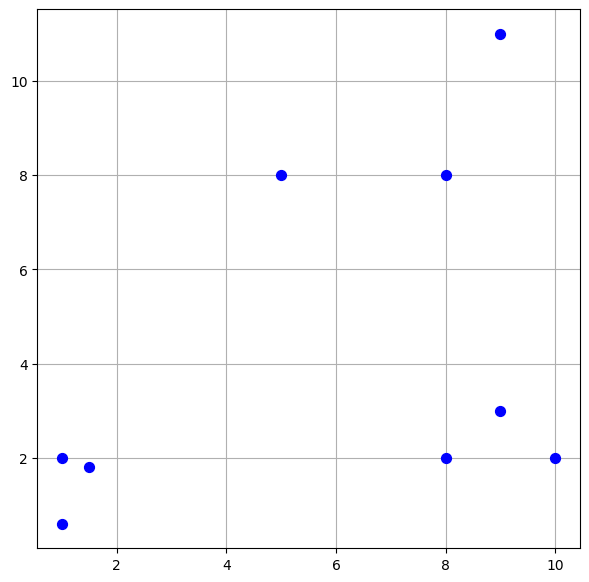

In [ ]:
X = sample_data.sample1

# 데이터 확인
print(X.shape)
print(X)

# 좌표에 그리기
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], color='b', s=50, zorder=2)
plt.grid()
plt.show()

In [ ]:
# meanshift 수행
bandwidth = 4
centroids, history = mean_shift(X, bandwidth)

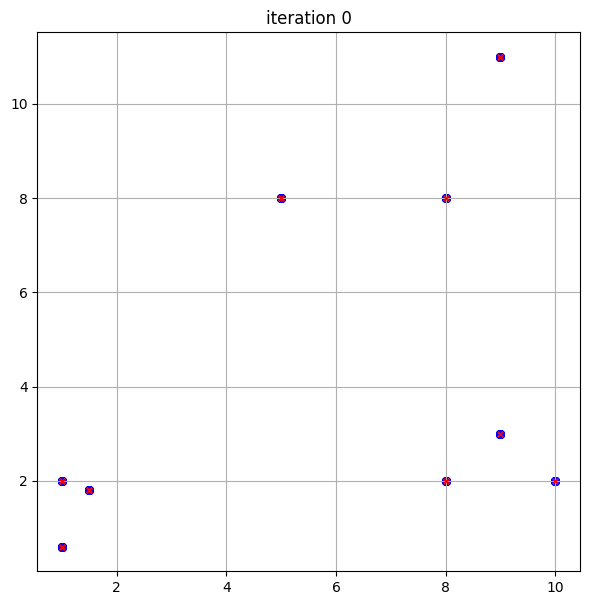

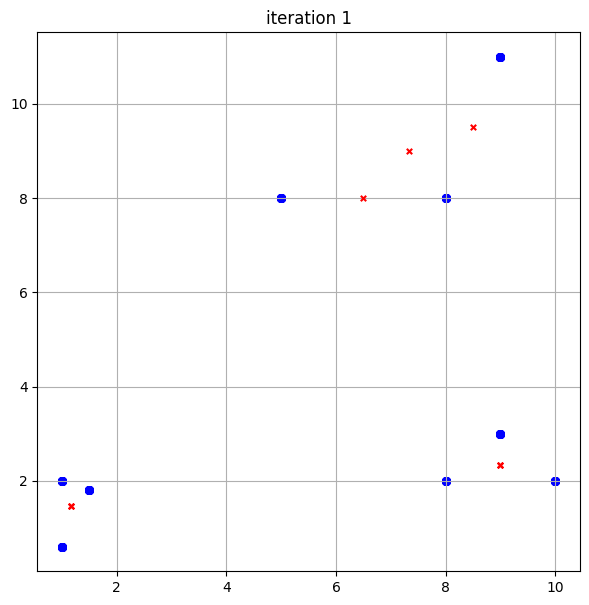

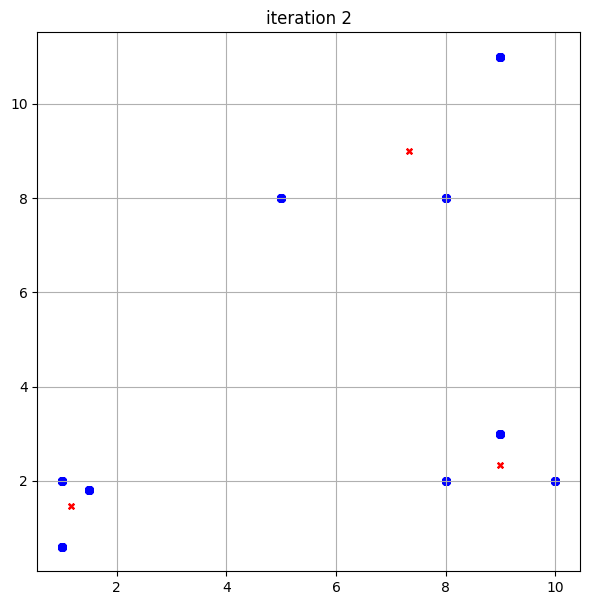

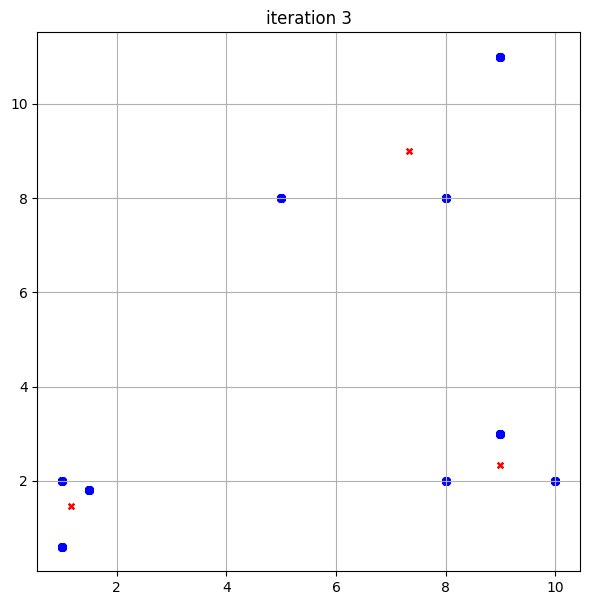

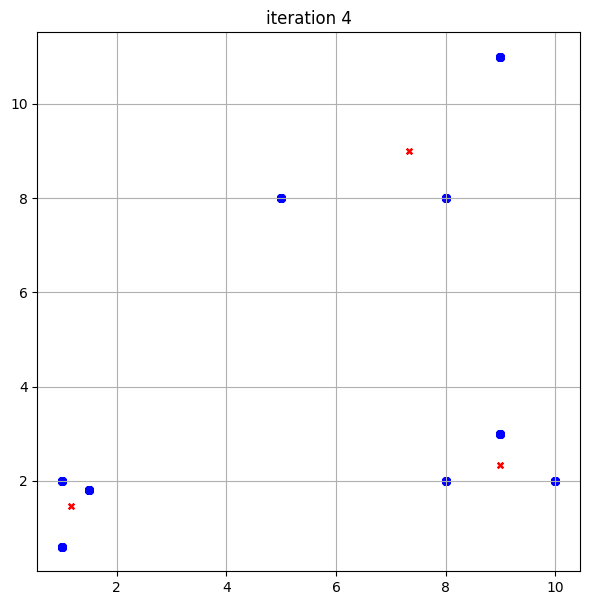

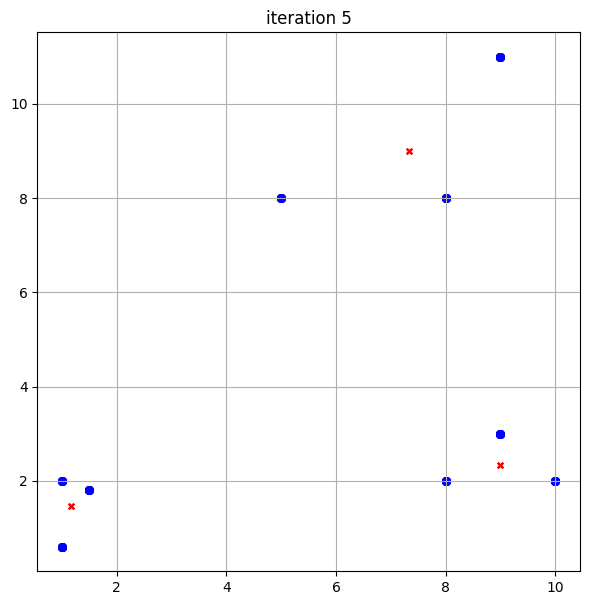

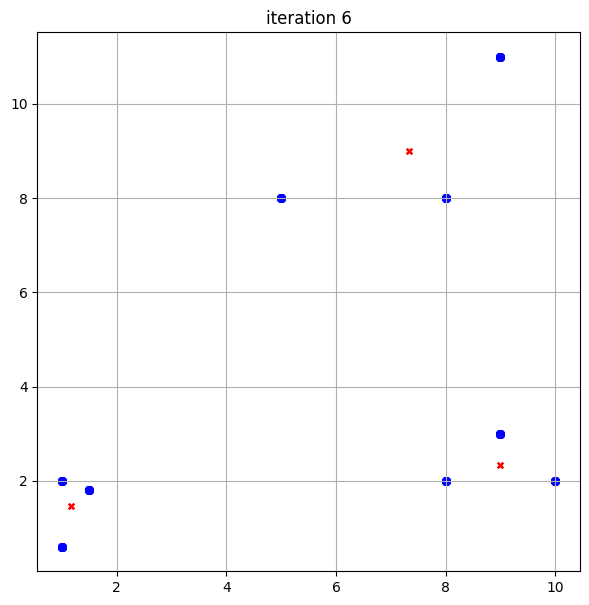

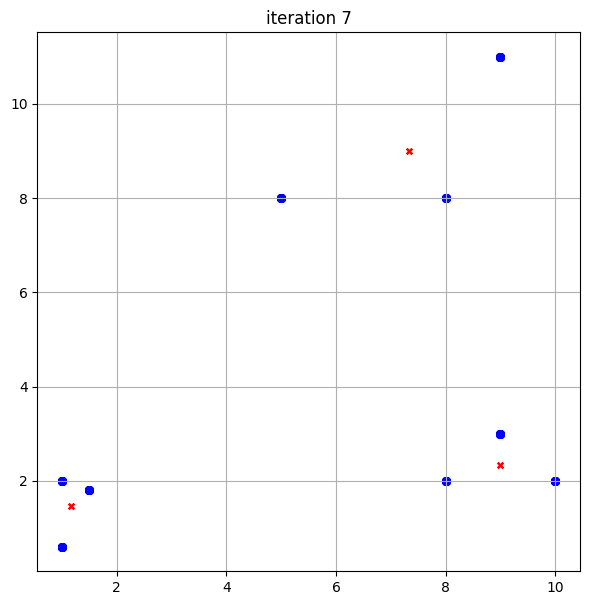

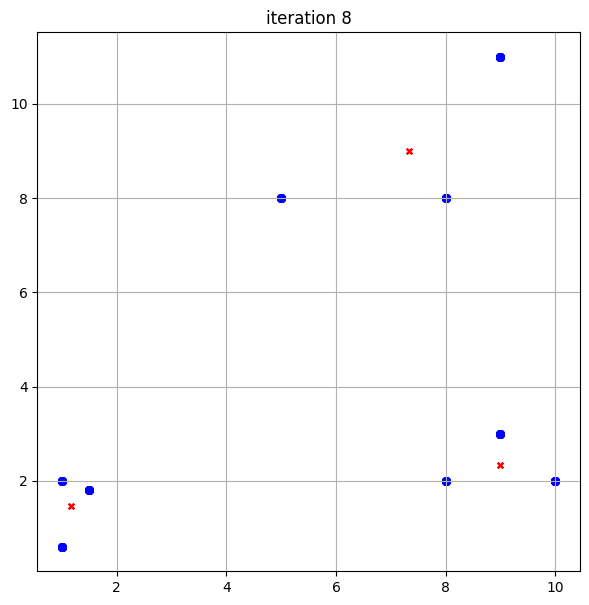

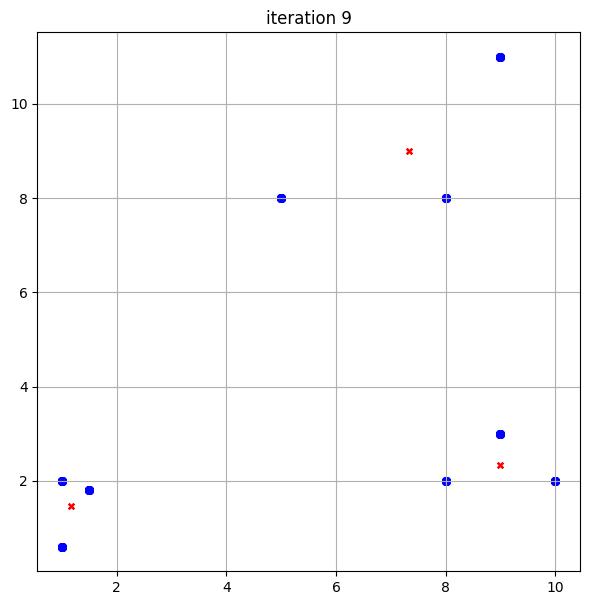

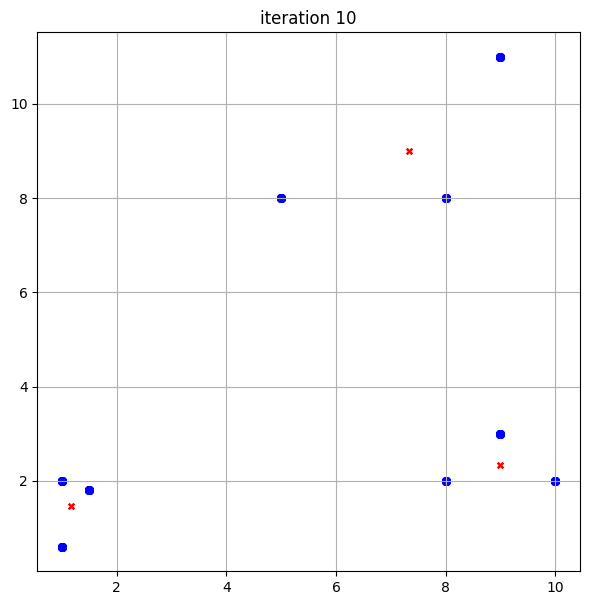

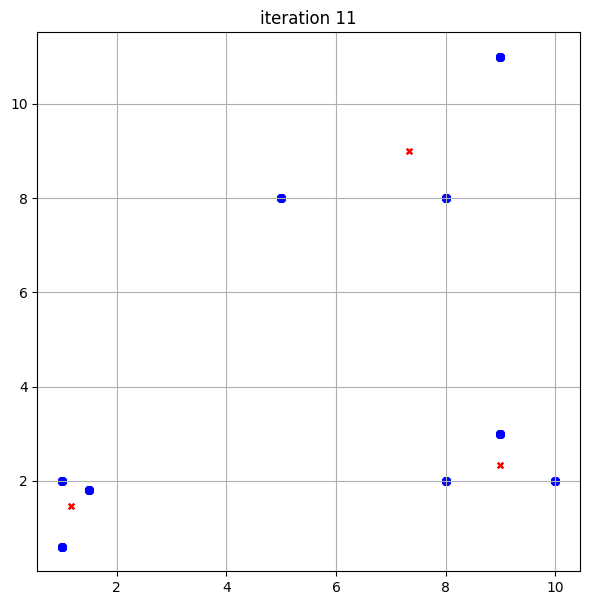

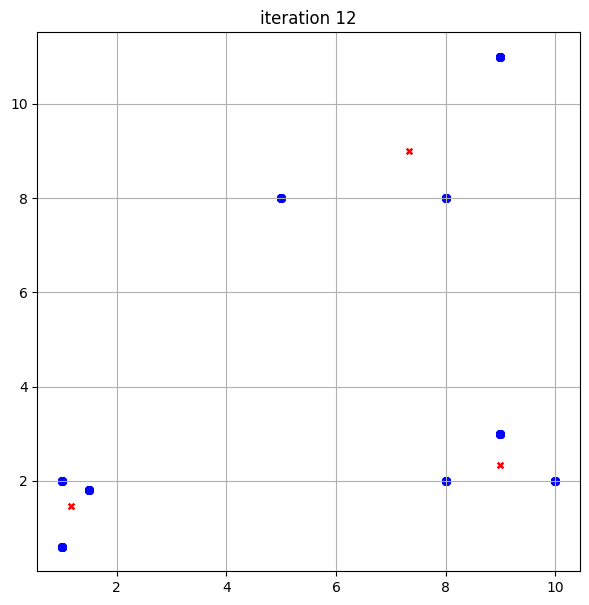

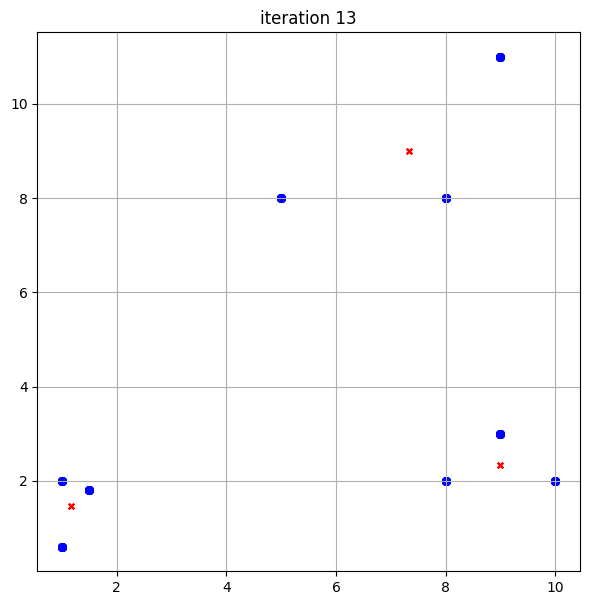

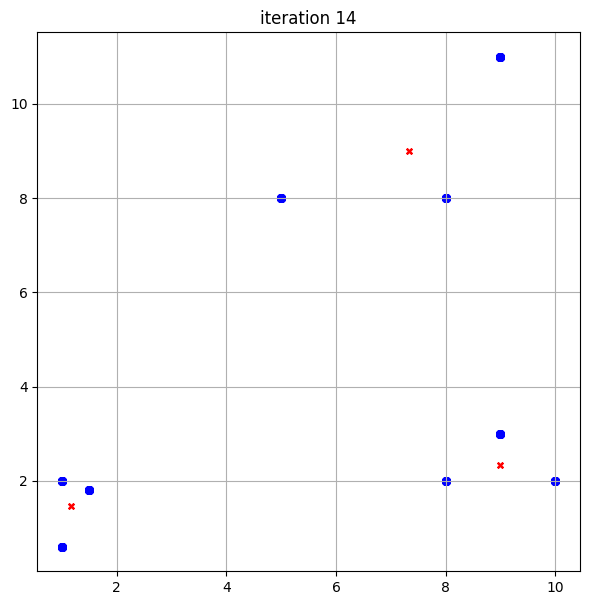

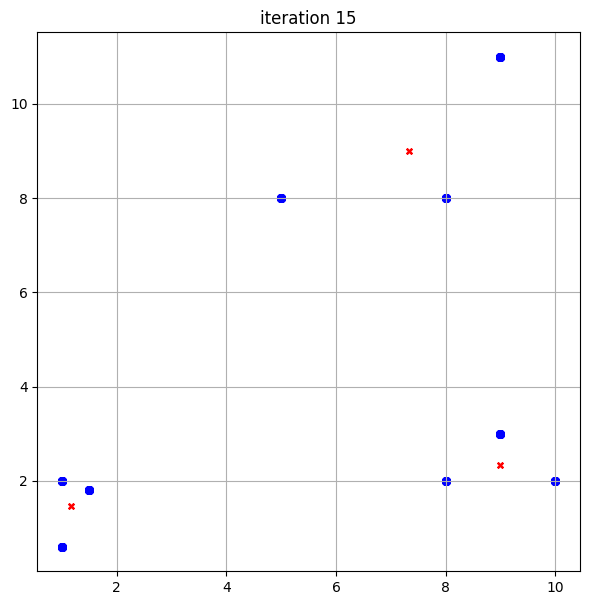

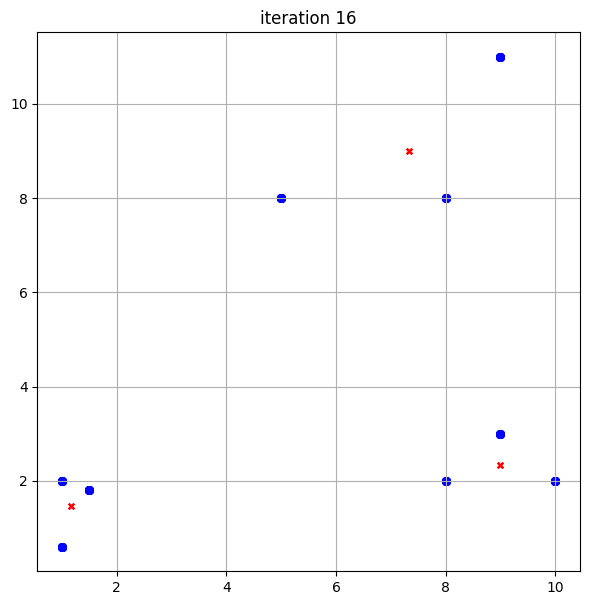

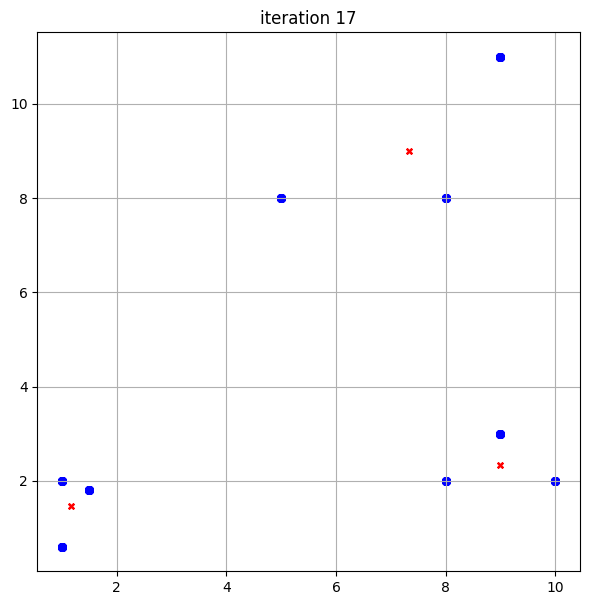

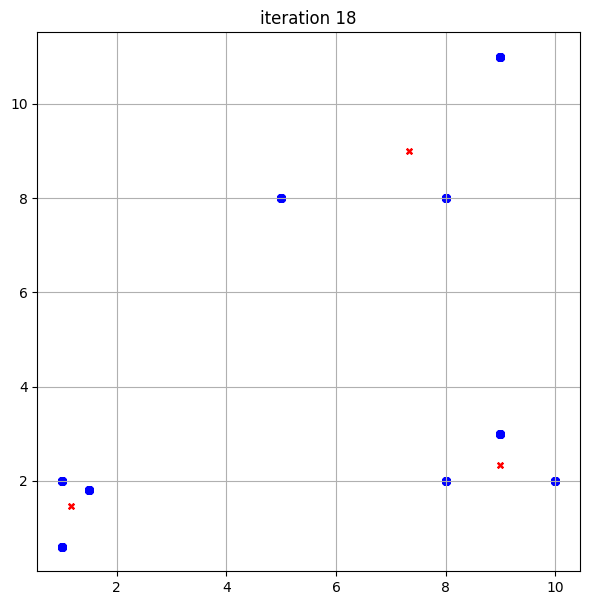

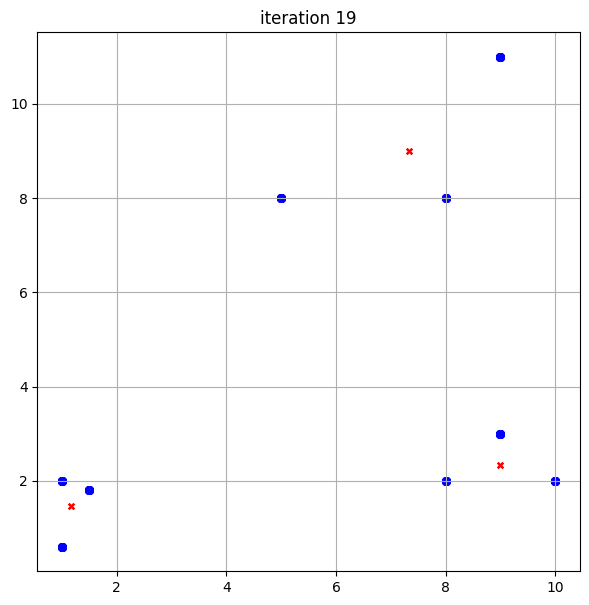

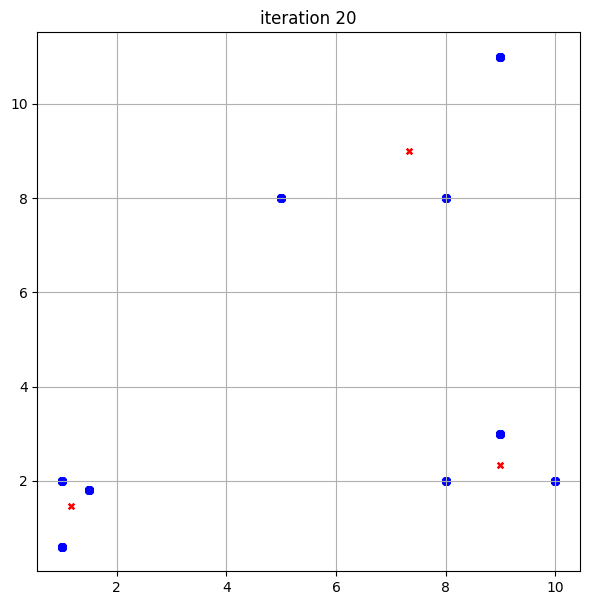

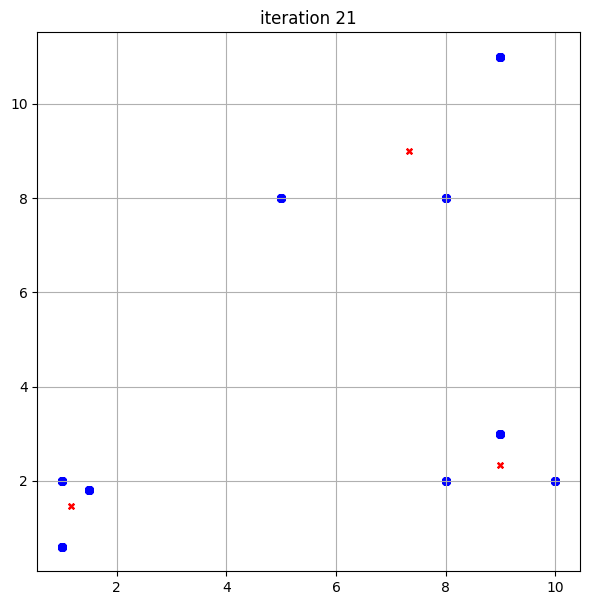

In [ ]:
hist = history
n_iter =max([len(arr) for arr in hist.values()])
for i in range(len(X)):
    n = len(hist[i])

    for j in range(n_iter):
        if j < n:
            hist[i][j] = (round(hist[i][j][0], 2), round(hist[i][j][1], 2))
        else:
            hist[i].append(hist[i][-1])

for i in range(n_iter):
    plt.figure(figsize=(7, 7))

    for j in range(len(X)):
        plt.scatter(X[:,0], X[:,1], color='b', marker='o',  s=30, zorder=1)
        plt.scatter(hist[j][i][0], hist[j][i][1], color='r', marker='x',  s=15, zorder=2)
    plt.title('iteration %d'%i)
    plt.grid()
    plt.show()

# Mean Shift 응용
- Object Tracking


In [ ]:
# 비디오 입력 받기
cap = cv2.VideoCapture('/content/drive/MyDrive/PR201910807/images/lab08/lab08_challenge.mp4')
ret, frame = cap.read()

# 추적 하고자 하는 위치 지정함 (x, y, w, h)
out_frame = frame.copy()
p, q, r, s = 400,100, 810, 180
track_window = (r, p, s, q)

# 타겟 영역 정하기
r_o_i = out_frame[p:p + q, r:r + s]

# HSV에서 히스토그램 역투영
hsv = cv2.cvtColor(r_o_i, cv2.COLOR_BGR2HSV)

# H값을 기준으로 히스토그램 생성
roi = cv2.calcHist([hsv], [0], None, [180], [0, 180])
# 정규화
cv2.normalize(roi, roi, 0, 255, cv2.NORM_MINMAX)

# Mean shift 알고리즘 종료 기준
termination = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 15, 2 )

# 출력 저장 'output.avi'
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('output.avi', fourcc, 25.0, (1280, 720))

while(True):
  ret, frame = cap.read()
  if not ret:
        break
  out_frame = frame.copy()

	# HSV로 색변환
  hsv = cv2.cvtColor(out_frame, cv2.COLOR_BGR2HSV)
	# 히스토그램 역투영 확률 데이터 얻기
  bp = cv2.calcBackProject([hsv], [0],roi,[0, 180], 1)

	# 역투영 확률값을 Mean shift 인자에 입력
  _, track_window = cv2.meanShift(bp, track_window,termination)

	# Tracking된 영역을 출력 frame에 표시
  x, y, w, h = track_window
  vid = cv2.rectangle(out_frame, (x, y), (x + w, y + h), 255, 2)

	# 출력 영상에 frame 저장
  out.write(vid)

# release cap object
cap.release()
out.release


<function VideoWriter.release>

- Segmentation

Number of segments:  8


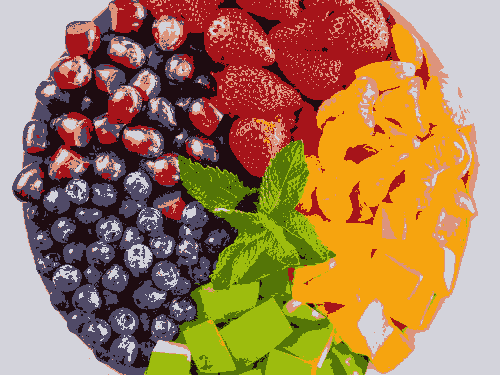

In [ ]:
from sklearn.cluster import MeanShift, estimate_bandwidth

img = cv2.imread('/content/drive/MyDrive/PR201910807/images/lab08/lab08_fruit.jpg')

# 블러링을 통한 노이즈 제거
img = cv2.GaussianBlur(img, (5, 5), 0.3)

# flatten the image
flat_image = img.reshape((-1,3))
flat_image = np.float32(flat_image)

# Mean shift
bandwidth = estimate_bandwidth(flat_image, quantile=.06, n_samples=3000)
ms = MeanShift(bandwidth=bandwidth, max_iter=800, bin_seeding=True)
ms.fit(flat_image)
labeled=ms.labels_

# Mean shift를 통해 Clustering 된 중심의 수
segments = np.unique(labeled)
print('Number of segments: ', segments.shape[0])

# 각 Cluster의 중심 색상 저장
total = np.zeros((segments.shape[0], 3), dtype=float)
count = np.zeros(total.shape, dtype=float)
for i, label in enumerate(labeled):
    total[label] = total[label] + flat_image[i]
    count[label] += 1
avg = total/count
avg = np.uint8(avg)

# 중심 색상으로 변경
res = avg[labeled]
result = res.reshape((img.shape))

# show the result
cv2_imshow(result)